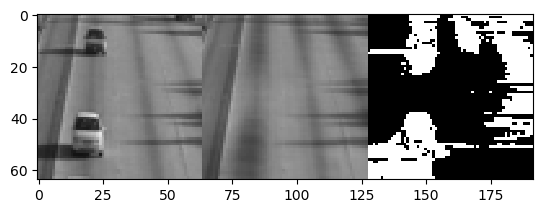

In [1]:
include("example_RPCA.jl")

# 1

In [2]:
using Printf
using Statistics
using LinearAlgebra
include("misc.jl")
include("findMin.jl")

function PCA(X,k)
    (n,d) = size(X)

    # Subtract mean
    mu = mean(X,dims=1)
    X -= repeat(mu,n,1)

    (U,S,V) = svd(X)
    W = V[:,1:k]'

    compress(Xhat) = compressFunc(Xhat,W,mu)
    expand(Z) = expandFunc(Z,W,mu)

    return CompressModel(compress,expand,W)
end

function compressFunc(Xhat,W,mu)
    (t,d) = size(Xhat)
    Xcentered = Xhat - repeat(mu,t,1)
    return Xcentered*W' # Assumes W has orthogonal rows
end

function expandFunc(Z,W,mu)
    (t,k) = size(Z)
    return Z*W + repeat(mu,t,1)
end

function PCA_gradient(X,k)
    (n,d) = size(X)

    # Subtract mean
    mu = mean(X,dims=1)
    X -= repeat(mu,n,1)

    # Initialize W and Z
    W = randn(k,d)
    Z = randn(n,k)

    R = Z*W - X
    f = sum(R.^2)
    funObjZ(z) = pcaObjZ(z,X,W)
    funObjW(w) = pcaObjW(w,X,Z)
    for iter in 1:50
        fOld = f

        # Update Z
        Z[:] = findMin(funObjZ,Z[:],verbose=false,maxIter=10)

        # Update W
        W[:] = findMin(funObjW,W[:],verbose=false,maxIter=10)

        R = Z*W - X
        f = sum(R.^2)
        @printf("Iteration %d, loss = %f\n",iter,f/length(X))

        if (fOld - f)/length(X) < 1e-2
            break
        end
    end


    # We didn't enforce that W was orthogonal so we need to optimize to find Z
    compress(Xhat) = compress_gradientDescent(Xhat,W,mu)
    expand(Z) = expandFunc(Z,W,mu)

    return CompressModel(compress,expand,W)
end

function compress_gradientDescent(Xhat,W,mu)
    (t,d) = size(Xhat)
    k = size(W,1)
    Xcentered = Xhat - repeat(mu,t,1)
    Z = zeros(t,k)

    funObj(z) = pcaObjZ(z,Xcentered,W)
    Z[:] = findMin(funObj,Z[:],verbose=false)
    return Z
end


function pcaObjZ(z,X,W)
    # Rezie vector of parameters into matrix
    n = size(X,1)
    k = size(W,1)
    Z = reshape(z,n,k)

    # Comptue function value
    R = Z*W - X
    f = HuberLoss(R)

    # Comptue derivative with respect to each residual
    dR = HuberLossGrad(R)

    # Multiply by W' to get elements of gradient
    G = dR*W'

    # Return function and gradient vector
    return (f,G[:])
end

function pcaObjW(w,X,Z)
    # Rezie vector of parameters into matrix
    d = size(X,2)
    k = size(Z,2)
    W = reshape(w,k,d)

    # Comptue function value
    R = Z*W - X
    f = HuberLoss(R)

    # Comptue derivative with respect to each residual
    dR = HuberLossGrad(R)

    # Multiply by Z' to get elements of gradient
    G = Z'dR

    # Return function and gradient vector
    return (f,G[:])
end

function HuberLoss(X, eps=0.01)
    (x,y) = size(X)
    loss = 0
    for i in 1:x
        for j in 1:y
            if abs(X[i,j]) > eps
                loss += eps * abs(X[i,j]) - eps^2/2
            else
                loss += X[i,j]^2/2
            end
        end
    end
    return loss
end 
    
function HuberLossGrad(X, eps=0.01)
    (x,y) = size(X)
    dX = zeros(x,y)
    for i in 1:x
        for j in 1:y
            if abs(X[i,j]) > eps
                dX[i,j] = eps * sign(X[i,j])
            else
                dX[i,j] = X[i,j]
            end
        end
    end
    return dX
end 

HuberLossGrad (generic function with 2 methods)

Iteration 1, loss = 657.157124


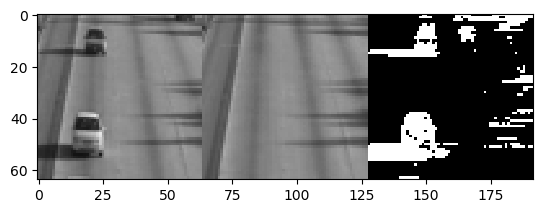

In [3]:
# Load X variable
using JLD
X = load("highway.jld","X")
(n,d) = size(X)

# # Fit PCA model
# include("PCA.jl")
k = 5
model = PCA_gradient(X,k)

Z = model.compress(X)
Xhat = model.expand(Z)

using PyPlot
nFrames = 50 # Number of frames to show
pause = 0.1 # How long to pause on each frame
for i in 1:nFrames
	original = reshape(X[i,:],64,64)
	reconstr = reshape(Xhat[i,:],64,64)
	diff = 255*(abs.(original-reconstr) .> 10)
	figure(1)
	clf()
	imshow([original reconstr diff],cmap="gray")
	sleep(pause)
end
